Workflow:
    - take notebook of most updated code for WIT
    - copy bits into this notebook
    - when this notebook runs
    - merge cells and copy into the merged_cells notebook
    - then test that 
    - then remove defaults and run on raijin   
    

### Before you run this on raijin:
-remove defaults #DesiredChunks and #part

### List of wetland edits

push to github every time you change one of these!!!!
- wofs bit flags - include low angle wofs
- check for 90% coverage of shape, not just load
- if no data, redo load with no 90% thing, then monthly aggregate before checking for coverage
-  tighten graph and increase text size


In [1]:
# #!/usr/bin/python


# | Authors:  | Bex Dunn|
# |----------|----------------|
# | Created: | Jan 7, 2019 |
# | Last edited: | April 17,2019 |


#  Before running this script load these modules:
# `module use /g/data/v10/public/modules/modulefiles` 
# `module load dea`
# This code is designed to run on raijin, on the Australian NCI. 
# The shell script to run this code has a *.sh extension

# changelog: incorporated wofs with terrain + low sensor angle shadow, otherwise we miss areas that are visibly
#            wet during winter months. This may cause issues in wetlands surrounded by terrain or veg that can 
#            shadow the surface and make it appear wet in indices.
#          : changed the no-data behaviour. We are now visualising as proportion of visible pixels, where the 
#            data within a box surrounding the query returned 90% good data. 

# 
# This code takes a supplied shapefile of a polygon and queries Digital Earth
# Australia http://geoscienceaustralia.github.io/digitalearthau/
# for WOfS, Fractional Cover and NBART. It calculates thresholded tasselled cap wetness. The dominant result for
# each pixel is calculated and the percentage area of the polygon covered by water, wet vegetation, 
# photosynthetic vegetation, non-photosynthetic vegetation and bare soil is output into a jpg stacked plot and to
# csv. The resulting data can be used to monitor changes in wetland behaviour spatiotemporally. 

# - Input Datasets:
# - Landsat 5
# - Landsat 7
# - Landsat 8

# -- Fractional Cover --
# - PV - Photosythetic vegetation
# - NPV - Non-Photosythetic vegetation
# - BS - Bare Soil

# - WOfS Feature Layers (WOFLs)

# __Future Work:__ 
# - do this by max extent of wetness        

### Import Statements: import the modules we need ------------------------------

import csv
import datacube
import datetime
import fiona
import geopandas as gpd
from math import ceil
import numpy as np
import pandas as pd
import rasterio.mask
import rasterio.features
from shapely import geometry
import seaborn as sns
import sys
import time
import xarray as xr

#keep the plotting modules in here as we want to output the stackplots to *.jpg
from datetime import datetime, timedelta
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

from datacube.storage import masking
from datacube.utils import geometry
from digitalearthau.utils import wofs_fuser

#append path to dea notebooks scripts to the system so we can access it
sys.path.append('/g/data/r78/rjd547/jupyter_notebooks/dea-notebooks/10_Scripts')
import DEADataHandling, DEAPlotting, TasseledCapTools

# setup the datacube 
dc = datacube.Datacube(app='wetlands insight tool')

### Set up polygon
poly_path='/g/data/r78/rjd547/Ramsar_Wetlands/shapefiles/ExplodedRAMSAR.shp'
print(f'Shape file is {poly_path}')

#part = sys.argv[1] #take an argument from the command line (our parallelish scripte)
#part = int(part)
#print(f'system argument received is {part}')

# #Desired number of chunks
# if len(sys.argv)<3:
#     print('Usage: this script takes 2 arguments - update your submission script')
# #DesiredChunks = int(sys.argv[2])

Shape file is /g/data/r78/rjd547/Ramsar_Wetlands/shapefiles/ExplodedRAMSAR.shp


In [7]:
#defaults 
#part =19 #coburg
#part = 15 #vic lakes
part = 13  
DesiredChunks=64

global Output_dir
Output_dir = '/g/data/r78/rjd547/Ramsar_Wetlands/Ramsar_Outputs_3_v2/'

# add in a delay between dc.load calls to avoid overloading the database - 5 seconds in this case
time.sleep(5*part)
#open the polygon

In [9]:
#this code tells us which polygon ids will be running on this particular (node?). Shapessubset will be the subset of polygons that our function
#will run over. 
with fiona.open(poly_path) as allshapes:
        #get the crs of the polygon file to use when processing each polygon
        crs = geometry.CRS(allshapes.crs_wkt)
        #get the list of all the shapes in the shapefile
        ShapesList = list(allshapes)
        ChunkSize = ceil(len(ShapesList)/DesiredChunks) #this was set due to Claire having 64000 polygons in her code
        print(f'chunk size is {ChunkSize}')
        print(f'There are {int(len(ShapesList)/ChunkSize)} generated chunks')
        shapessubset = allshapes[(part - 1) * ChunkSize: part * ChunkSize]
        print(f'Running for polygon IDs in the range {(part - 1) * ChunkSize} to {part * ChunkSize}')  

chunk size is 5
There are 54 generated chunks
Running for polygon IDs in the range 60 to 65


/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/fiona/collection.py:336: FionaDeprecationWarning: Collection slicing is deprecated and will be disabled in a future version.
  return self.session.__getitem__(item)


### define functions that are run in the mainline here

In [10]:
def get_RAMSAR_polyName(shapefile):
    ''' function designed specifically for the RAMSAR wetlands australia shapefile. Takes the shapefile and extracts
    the ramsar name, wetland name and objectID from the ESRI shapefile format and turns it into a useful string for our output.
    :Inputs: shapefile with RAMSAR_NAM, WETLAND_NA, and OBJECTID as properties. 
    Author: Bex Dunn Last Edited: March 2019'''
    # get the ramsar name from the shapes 
    RAMSAR_NAME = '_'.join(shapefile['properties']['RAMSAR_NAM'].split(' '))
    WETLAND_NAME = '_'.join(shapefile['properties']['WETLAND_NA'].split(' '))
    STATE = '_'.join(shapefile['properties']['STATE'].split(' ')) 
    ID = shapefile['id']
    polyName = f'{RAMSAR_NAME}-{WETLAND_NAME}-{STATE}-{ID}'
    print(f'processing polygon {polyName}')
    return(polyName)

In [11]:
def get_masked_ls578_data(query, geom):
    '''create a function that takes in the masked proportion, query and geometry and returns the fully masked surface reflectance data'''
    ## Set up datasets
    #set cloudmasking threshold and load landsat nbart data
    landsat_masked_prop = 0.90
    ls578_ds = DEADataHandling.load_clearlandsat(dc=dc, query=query, product='nbart',
            masked_prop=landsat_masked_prop)

    ### mask the data with our original polygon to remove extra data 

    data = ls578_ds
    mask = rasterio.features.geometry_mask([geom.to_crs(data.geobox.crs)for geoms in [geom]],
                                               out_shape=data.geobox.shape,
                                               transform=data.geobox.affine,
                                               all_touched=False,
                                               invert=False)

    #for some reason xarray is not playing nicely with our old masking function
    mask_xr = xr.DataArray(mask, dims = ('y','x'))
    ls578_ds = data.where(mask_xr==False)
    return ls578_ds, mask_xr

In [12]:
def get_masked_tcw(sr_data, mask, threshold=-350):
    '''uses TasseledCapTools and an input threshold (defaults to -350) to create masked over-threshold tasseled cap '''

    #transform the nbart into tci
    tci = TasseledCapTools.thresholded_tasseled_cap(sr_data,wetness_threshold=-350, drop=True , drop_tc_bands=True)

    #select only finite values (over threshold values)
    tcw = xr.ufuncs.isfinite(tci.wetness_thresholded)

    # #reapply the polygon mask
    tcw = tcw.where(mask==False)

    return tcw

In [13]:
def BigBadFunkyFunction(lilshape,crs):
    '''This is a function that does lots of things. It takes a single polygon and does all the things #FIXME '''
### This is set up to be shapefile-specific. I'm not sure this can be avoided, as often shapefiles are pretty specific..
    try:
        first_geometry = lilshape['geometry']
        polyName = get_RAMSAR_polyName(lilshape)
        geom = geometry.Geometry(first_geometry, crs=crs)
        query = {'geopolygon': geom}#, 'time': ('2001-01-01', '2003-01-01') }# this should run for all time, if there is no time set?
        #load and mask data. selecting data with more than 90% clear for the geobox around the polygon... #FIXME
        ls578_ds, mask_xr= get_masked_ls578_data(query,geom)
        print('running tasselled cap transform')
        #calculate tasselled cap wetness within masked AOI
        tcw = get_masked_tcw(ls578_ds, mask_xr, threshold=-350)
        print('ran tasselled cap transform')
        ### load wofls and select only wet pixels
        print('loading wofls')

        #wofls = dc.load(product = 'wofs_albers', like=ls578_ds, fuse_func=wofs_fuser)
        wofls = dc.load(product = 'wofs_albers',fuse_func=wofs_fuser, **query)
        #match wofs to tcw, because we didn't filter wofs for slc-off yet
        wofls = wofls.where(wofls.time==tcw.time)
        # #reapply the polygon mask
        wofls = wofls.where(mask_xr==False)
        #use bit values in wofs to select wet observations
        wet_wofs = wofls.where(wofls.water==128)
        #but also get the terrain and low-angle shadow wofs for this application
        shadow_wofs = wofls.where(wofls.water== 136) #use bit values for wet (128) and terrain/low-angle (8)
        print('wet and shadowed wofls acquired')

        #------
        #create a combined wofs dataset to mask fractional cover with
        all_wofs=wet_wofs.copy(deep=True)
        #fill wet_wofs with shadow_wofs, where wet_wofs is nan
        combined_wofs = all_wofs.fillna(shadow_wofs)


        ### load in fractional cover data
        print('loading fractional cover data')
        #load the data according to our query
        #choose a mask proportion to look for a clear timestep
        fc_ds = DEADataHandling.load_clearlandsat(dc, query,product='fc',masked_prop=0.90)

        ### mask FC with polygon
        fc_ds = fc_ds.where(mask_xr==False)

        ### mask FC with wetness
        fc_ds_noTCW=fc_ds.where(tcw==False)
        #match timesteps
        fc_ds_noTCW= fc_ds_noTCW.where(fc_ds_noTCW.time==tcw.time)
        print('loaded fractional cover data')

        print('calculating dominant fraction for each Fractional Cover pixel')
        #drop data percentage and Unmixing Error
        fc_tester = fc_ds_noTCW.drop(['data_perc','UE'])

        #following robbi's advice, cast the dataset to a dataarray
        maxFC = fc_tester.to_array(dim='variable', name='maxFC')

        #turn FC array into integer only as nanargmax doesn't seem to handle floats the way we want it to
        FC_int = maxFC.astype('int8')

        #use numpy.nanargmax to get the index of the maximum value along the variable dimension
        #BSPVNPV=np.nanargmax(FC_int, axis=0)
        BSPVNPV=FC_int.argmax(dim='variable')

        #work out where we have actual values!
        FC_mask=xr.ufuncs.isfinite(maxFC).all(dim='variable')

        # #re-mask with nans to remove no-data
        BSPVNPV=BSPVNPV.where(FC_mask)

        #restack the Fractional cover dataset all together
        FC_dominant = xr.Dataset({
            'BS': (BSPVNPV==0).where(FC_mask),
            'PV': (BSPVNPV==1).where(FC_mask),
            'NPV': (BSPVNPV==2).where(FC_mask),
        })
        # count number of Fractional Cover pixels for each cover type in area of interest
        FC_count = FC_dominant.sum(dim=['x','y'])

        ### Calculate number of pixels in area of interest
        #number of pixels in area of interest
        pixels = (mask_xr==0).sum(dim=['x','y'])

        #count number of tcw pixels
        tcw_pixel_count = tcw.sum(dim=['x','y'])

        #count number of wofs pixels
        wofs_pixels = wet_wofs.water.count(dim=['x','y'])+shadow_wofs.water.count(dim=['x','y'])

        #count percentage of area of wofs
        wofs_area_percent = (wofs_pixels/pixels)*100

        #count number of tcw pixels
        tcw_pixel_count = tcw.sum(dim=['x','y'])

        #calculate percentage area wet
        tcw_area_percent = (tcw_pixel_count/pixels)*100

        #calculate wet not wofs
        tcw_less_wofs = tcw_area_percent-wofs_area_percent

        ### tasselled cap can actually be less than wofs!! (this is generally a bad sign... but possible)
        # this will put a nan in here and wipe out the entire timestep. which is kinda what we want.
        #tcw_less_wofs= tcw_less_wofs.where(tcw_less_wofs >0)
        #alternatively we can gap fill with a 0. which is a bit sneaky and wrong
        tcw_less_wofs = tcw_less_wofs.where(tcw_less_wofs>0,0)

        ###Fractional cover pixel count method
        #Get number of FC pixels, divide by total number of pixels per polygon
        #Work out the number of nodata pixels in the data, so that we can graph the variables by number of observed pixels.

        Bare_soil_percent=(FC_count.BS/pixels)*100

        Photosynthetic_veg_percent=(FC_count.PV/pixels)*100

        NonPhotosynthetic_veg_percent=(FC_count.NPV/pixels)*100

        NoData = 100 - wofs_area_percent- tcw_less_wofs - Photosynthetic_veg_percent - NonPhotosynthetic_veg_percent - Bare_soil_percent

        NoDataPixels = (NoData/100) * pixels

        #now scale %of area by % of observed area using the number of actually observed pixels

        Bare_soil_percent2=(FC_count.BS/(pixels - NoDataPixels))*100

        Photosynthetic_veg_percent2=(FC_count.PV/(pixels- NoDataPixels))*100

        NonPhotosynthetic_veg_percent2=(FC_count.NPV/(pixels- NoDataPixels))*100

        #recalculate wofs area %
        wofs_area_percent2 = (wofs_pixels/(pixels - NoDataPixels))*100
        #recount tcw %
        tcw_pixel_count2 = tcw.sum(dim=['x','y'])

        #recalculate percentage area wet
        tcw_area_percent2 = (tcw_pixel_count2/(pixels - NoDataPixels))*100

        #recalculate percentage area wet
        tcw_area_percent2 = (tcw_pixel_count2/(pixels - NoDataPixels))*100

        #recalculate wet not wofs
        tcw_less_wofs2 = tcw_area_percent2-wofs_area_percent2

        #alternatively we can gap fill with a 0. which is a bit sneaky and wrong
        tcw_less_wofs2 = tcw_less_wofs2.where(tcw_less_wofs2>0,0)

        #last check for timestep matching before we plot
        wofs_area_percent2=wofs_area_percent2.where(wofs_area_percent2.time==Bare_soil_percent2.time)
        Bare_soil_percent2=Bare_soil_percent2.where(Bare_soil_percent2.time==wofs_area_percent2.time)
        Photosynthetic_veg_percent2=Photosynthetic_veg_percent2.where(Photosynthetic_veg_percent2.time==wofs_area_percent2.time)
        NonPhotosynthetic_veg_percent2=NonPhotosynthetic_veg_percent2.where(NonPhotosynthetic_veg_percent2.time==wofs_area_percent2.time)


        #set up color palette
        pal = [sns.xkcd_rgb["cobalt blue"],
               sns.xkcd_rgb["neon blue"],
               sns.xkcd_rgb["grass"],
               sns.xkcd_rgb["beige"],
               sns.xkcd_rgb["brown"]]       

        #make a stacked area plot
        plt.clf()
        fig= plt.figure(figsize = (12,4))
        plt.stackplot(wofs_area_percent.time.values, 
                      wofs_area_percent2, 
                      tcw_less_wofs2, 
                      Photosynthetic_veg_percent2, 
                      NonPhotosynthetic_veg_percent2,
                      Bare_soil_percent2,
                      labels=['open water',
                              'wet',
                              'green veg',
                              'dry veg',
                              'bare soil',
                             ], colors=pal, alpha = 0.6)
        plt.title(f'Percentage of area WOfS, Wetness, Fractional Cover for {polyName}')


        #set axis limits to the min and max
        plt.axis(xmin = wofs_area_percent2.time[0].data, xmax = wofs_area_percent2.time[-1].data, ymin = 0, ymax = 100)

        #add a legend and a tight plot box
        plt.legend(loc='lower left', framealpha=0.6)
        plt.tight_layout()

        #create rectangle borders for no-data times (SLC-off only)
        LS5_8_gap_start = datetime(2011,11,1)
        LS5_8_gap_end = datetime(2013,4,1)

        # convert to matplotlib date representation
        gap_start = mdates.date2num(LS5_8_gap_start)
        gap_end = mdates.date2num(LS5_8_gap_end)
        gap = gap_end - gap_start


        #set date ticks every year
        years = mdates.YearLocator(2)
        yearsFmt = mdates.DateFormatter('%Y')
        ax = plt.gca()
        ax.xaxis.set_major_locator(years)
        ax.xaxis.set_major_formatter(yearsFmt)
        #ax.yaxis.set_ticks(np.arange(0,110,10))
        ax.set_xlabel(f'The Fractional Cover algorithm developed by the Joint Remote'
        f' Sensing Research Program and \n the Water Observations from Space algorithm '
        f'developed by Geoscience Australia are used in the production of this data',style='italic')


        #set up rectangle
        slc_rectangle= Rectangle((gap_start,0), gap, 100,alpha = 0.5, facecolor=sns.xkcd_rgb['white'],
                     edgecolor=sns.xkcd_rgb['white'], hatch="////",linewidth=2)
        ax.add_patch(slc_rectangle)
        #fig.autofmt_xdate()

        #save the figure
        plt.savefig(f'{Output_dir}{polyName}.png')#, transparent=True)
        plt.show()
        print(f'plot created for {polyName}')

        #make a new dataframe using the data from the xarray of wofs area for the polygon

        ### start setup of dataframe by adding only one dataset
        WOFS_df = pd.DataFrame(data=wofs_area_percent2.data, index=wofs_area_percent2.time.values,columns=['wofs_area_percent'])

        #add data into pandas dataframe for export
        WOFS_df['tcw_area_percent']=tcw_less_wofs2.data
        WOFS_df['PV_percent']=Photosynthetic_veg_percent2.data
        WOFS_df['NPV_percent']=NonPhotosynthetic_veg_percent2.data
        WOFS_df['BS_percent']=Bare_soil_percent2.data

        #call the composite dataframe something sensible, like PolyDrill
        PolyDrill_df = WOFS_df.round(2)

        #save the csv of the output data used to create the stacked plot for the polygon drill
        PolyDrill_df.to_csv(f'{Output_dir}{polyName}.csv')
        print(f'wrote output data to file {Output_dir}{polyName}.csv')
        return 1
    except:
        print(f'did not run for {polyName}')

processing polygon Port_Phillip_Bay_(Western_Shoreline)_and_Bellarine_Peninsula-Point_Cook-VIC-60
Loading ls5
    Loading 253 filtered ls5 timesteps
Loading ls7
    Ignoring SLC-off observations for ls7
    Loading 61 filtered ls7 timesteps
Loading ls8
    Loading 94 filtered ls8 timesteps
Combining and sorting ls5, ls7, ls8 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)
running tasselled cap transform
ran tasselled cap transform
loading wofls
wet and shadowed wofls acquired
loading fractional cover data
Loading ls5
    Loading 253 filtered ls5 timesteps
Loading ls7
    Ignoring SLC-off observations for ls7
    Loading 61 filtered ls7 timesteps
Loading ls8
    Loading 94 filtered ls8 timesteps
Combining and sorting ls5, ls7, ls8 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)
loaded fractional cover data
calculating dominant fraction for each Fractional Cover pixel


<Figure size 432x288 with 0 Axes>

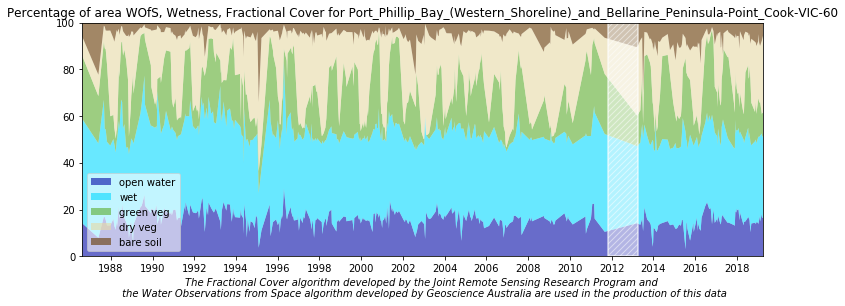

plot created for Port_Phillip_Bay_(Western_Shoreline)_and_Bellarine_Peninsula-Point_Cook-VIC-60
wrote output data to file /g/data/r78/rjd547/Ramsar_Wetlands/Ramsar_Outputs_3_v2/Port_Phillip_Bay_(Western_Shoreline)_and_Bellarine_Peninsula-Point_Cook-VIC-60.csv
processing polygon Port_Phillip_Bay_(Western_Shoreline)_and_Bellarine_Peninsula-Swan_Bay-VIC-61
Loading ls5
    Loading 203 filtered ls5 timesteps
Loading ls7
    Ignoring SLC-off observations for ls7
    Loading 54 filtered ls7 timesteps
Loading ls8
    Loading 81 filtered ls8 timesteps
Combining and sorting ls5, ls7, ls8 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)
running tasselled cap transform
ran tasselled cap transform
loading wofls
wet and shadowed wofls acquired
loading fractional cover data
Loading ls5
    Loading 203 filtered ls5 timesteps
Loading ls7
    Ignoring SLC-off observations for ls7
    Loading 54 filtered ls7 timesteps
Loading ls8
    Loading 81 filtered ls8 timesteps
Comb

<Figure size 432x288 with 0 Axes>

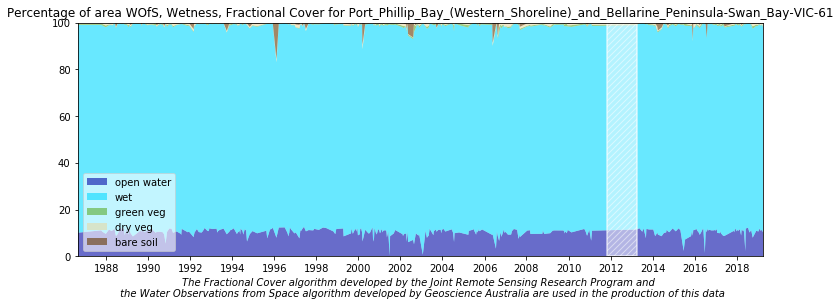

plot created for Port_Phillip_Bay_(Western_Shoreline)_and_Bellarine_Peninsula-Swan_Bay-VIC-61
wrote output data to file /g/data/r78/rjd547/Ramsar_Wetlands/Ramsar_Outputs_3_v2/Port_Phillip_Bay_(Western_Shoreline)_and_Bellarine_Peninsula-Swan_Bay-VIC-61.csv
processing polygon Port_Phillip_Bay_(Western_Shoreline)_and_Bellarine_Peninsula-Werribee_River-VIC-62
Loading ls5
    Loading 97 filtered ls5 timesteps
Loading ls7
    Ignoring SLC-off observations for ls7
    Loading 21 filtered ls7 timesteps
Loading ls8
    Loading 39 filtered ls8 timesteps
Combining and sorting ls5, ls7, ls8 data
did not run for Port_Phillip_Bay_(Western_Shoreline)_and_Bellarine_Peninsula-Werribee_River-VIC-62
first go did not succeed
processing polygon Port_Phillip_Bay_(Western_Shoreline)_and_Bellarine_Peninsula-Werribee_River-VIC-62
Loading ls5
    Loading 97 filtered ls5 timesteps
Loading ls7
    Ignoring SLC-off observations for ls7
    Loading 21 filtered ls7 timesteps
Loading ls8
    Loading 39 filtered ls8 t

In [ ]:
 # Mainline
    #-----------------------------------------------------------------------#

# Launch a process for each polygon.

### for each shapefile in our subset of shapefiles:
for shapes in shapessubset:
    ### try to run the function once, for the shapefile and given crs
    result = BigBadFunkyFunction(shapes, crs)
    ### if result is False ie. doesn't run
    if not result: 
        print('first go did not succeed')
        ### Try to run the function again
        result = BigBadFunkyFunction(shapes, crs)
        ### if that didn't work:    
        if not result:
            print('second go did not succeed, running for last time')
            ### try for a third and last time
            result = BigBadFunkyFunction(shapes, crs)   